# Plot bathymetry at selected station location 

#### Input files
1. Global topography from Smith & Sandwell (1997), 1 min resolution. You can find it here: https://topex.ucsd.edu/marine_topo/ in the section "Global Topography": https://topex.ucsd.edu/pub/global_topo_1min/ At the same link, you can also find other bathymetric products at higher resolution. 
2. Track file. This is a csv file which includes station number, longitude, latitude, and station depth. This file is needed for many cruise code, and usually will have ports indicate with station number 0

#### What does the code do?
The code reads in the topography file and the track file. The user will select the station number of interest. The code will then find that location in the global bathymetry file and plot the bathymetry contours at the selected station within a ~6nm radius. It will also add a 0.5nm radius circle, which is more or less the distance that the ship will drift while on station (this is inevitable to make sure that the winch cable remains straight; depending on the condition, the drift could be a bit more). The User can change the radius and resolution of the bathymetry.

Why you might need this code? This code is useful to check for bathymetric slope before a cast. This can be used to inform the bridge (if needed) on which preferential direction to drift, i.e. you would want to drift downgradient and not upgradient (into the slope!). Note that the drifting direction ultimately will also depend on the current and wind velocity & directions. This plot would at least help you make an informed decision, for example on whether to stop at 15 m from the bottom or whether to ask the winch to come up "as fast as they can", which is usually 75 mpm (rather than the standard 60 mpm).

#### For future cruises 
Simply input a new track file and change paths to input files - then you should be ready to go!

Code by L.Cimoli, April 2023
For questions, email lc929@cam.ac.uk

In [1]:
# Import libraries
import netCDF4
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# Set user variables for plot

# Select path where you want to save the outputs, the cruise name and some figure settings
path2outputs = ""
trk_name = "A16N"
paramfig = {"dpi": 300, "outformat": "png", "do_saving": False}

station_we_are_at = 150  # where are we

# Lat/Lon limits for a radius around the station. Change the +- values to have a smaller or larger radius
# 1nm = 0.0167 dec
# 2nm = 0.033 dec
# 5nm = 0.0833 dec
d_latlon = 0.1
ship_rad = 0.0167


In [3]:
# Import TOPOGRAPHY FILE
fp = "../../inputs/topography/topo_25.1.nc"  # your file name with the eventual path
nc = netCDF4.Dataset(fp)

FileNotFoundError: [Errno 2] No such file or directory: '../../inputs/topography/topo_25.1.nc'

In [4]:
# Import TRACK INFO
datafilepath = "../../inputs/goship/"
trk_name = "a16n_2023_track_leg2"
trk = pd.read_csv(f"{datafilepath}{trk_name}.csv")

trk = trk[trk.depth != 0]  # Remove ports
trk = trk.set_index("station")  # Change index to station number

In [5]:
# Latmin/latmax and lonmin/lonmax are used to select the area with ~6nm-radius around the station location
latmin = trk.loc[station_we_are_at]["latitude"] - d_latlon
latmax = trk.loc[station_we_are_at]["latitude"] + d_latlon
lonmax = trk.loc[station_we_are_at]["longitude"] - d_latlon
# longitude is -ve
lonmin = trk.loc[station_we_are_at]["longitude"] + d_latlon

In [6]:
# Extract bathymetry values within selected area

lat, lon, topo = nc.variables["lat"], nc.variables["lon"], nc.variables["z"]
latvals = lat[:]
lonvals = lon[:]
topovals = topo[:]

# Values within ~6nm radius
latlims = latvals[(latvals >= latmin) & (latvals <= latmax)]
lonlims = lonvals[(lonvals <= lonmin) & (lonvals >= lonmax)]

# Get topography
topogr = topovals[(latvals >= latmin) & (latvals <= latmax), :]
topogr = topogr[:, (lonvals <= lonmin) & (lonvals >= lonmax)]
topogr.shape

(12, 12)

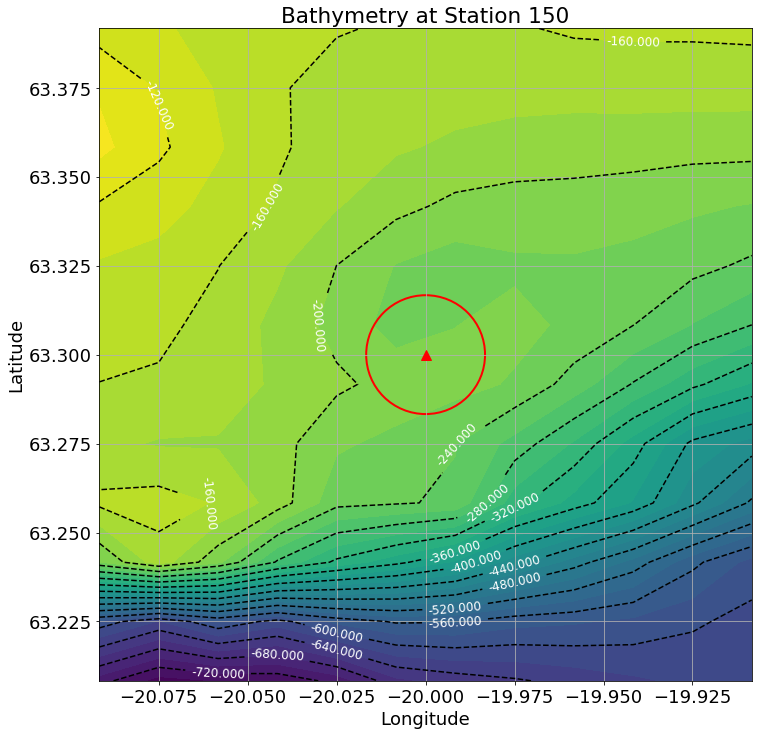

In [9]:
# Plot topography around station

figure(figsize=(12, 12))
plt.rcParams.update({"font.size": 18})
fig = plt.gcf()
ax = fig.gca()
plt.contourf(lonlims, latlims, topogr, 32)
cs = plt.contour(lonlims, latlims, topogr, 16, colors="black")
plt.plot(
    trk.longitude.loc[station_we_are_at],
    trk.latitude.loc[station_we_are_at],
    "r^",
    ms=10,
)
circle1 = plt.Circle(
    (trk.loc[station_we_are_at]["longitude"], trk.loc[station_we_are_at]["latitude"]),
    ship_rad,
    color="r",
    fill=False,
    lw=2,
)
ax.add_patch(circle1)
plt.clabel(cs, colors="w", inline=True, fontsize=12)
plt.grid(visible=True, which="both")
# plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Bathymetry at Station {station_we_are_at}")
ax.set_aspect("equal")

if paramfig["do_saving"]:
    plt.savefig(
        fname=f"{path2outputs}{trk_name}_topography_station_{station_we_are_at}.{paramfig['outformat']}",
        dpi=paramfig["dpi"],
    )